In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [57]:
imd_files = "Dependent /*.nc"
rain_ds = xr.open_mfdataset(imd_files, combine="by_coords")

In [59]:
rain_ds

<xarray.Dataset>
Dimensions:    (TIME: 1461, LONGITUDE: 35, LATITUDE: 33)
Coordinates:
  * TIME       (TIME) datetime64[ns] 2014-01-01 2014-01-02 ... 2017-12-31
  * LONGITUDE  (LONGITUDE) float64 66.5 67.5 68.5 69.5 ... 97.5 98.5 99.5 100.5
  * LATITUDE   (LATITUDE) float64 6.5 7.5 8.5 9.5 10.5 ... 35.5 36.5 37.5 38.5
Data variables:
    RAINFALL   (TIME, LATITUDE, LONGITUDE) float64 dask.array<chunksize=(365, 33, 35), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.7.1 (http://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Mon Mar 28 13:52:20 2022: cdo setmissval,-999 ind2014_1384i...
    CDO:          Climate Data Operators version 1.9.7.1 (http://mpimet.mpg.d...

In [90]:
era_files = "imd-datasets/*.nc"
era_ds = xr.open_mfdataset(era_files, combine="by_coords")

In [92]:
era_ds

<xarray.Dataset>
Dimensions:         (valid_time: 1342, pressure_level: 8, latitude: 21,
                     longitude: 9)
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 2014-06-01 ... 2024-09-30
  * pressure_level  (pressure_level) float64 1e+03 925.0 850.0 ... 250.0 200.0
  * latitude        (latitude) float64 20.0 19.75 19.5 19.25 ... 15.5 15.25 15.0
  * longitude       (longitude) float64 72.0 72.25 72.5 ... 73.5 73.75 74.0
Data variables:
    number          (valid_time) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    expver          (valid_time) object dask.array<chunksize=(122,), meta=np.ndarray>
    z               (valid_time, pressure_level, latitude, longitude) float32 dask.array<chunksize=(122, 8, 21, 9), meta=np.ndarray>
    q               (valid_time, pressure_level, latitude, longitude) float32 dask.array<chunksize=(122, 8, 21, 9), meta=np.ndarray>
    t               (valid_time, pressure_level, latitude, longitude) float32 dask.array<chunksize=(122, 8, 21, 9), meta=np.ndarray>
    u               (valid_time, pressure_level, latitude, longitude) float32 dask.array<chunksize=(122, 8, 21, 9), meta=np.ndarray>
    v               (valid_time, pressure_level, latitude, longitude) float32 dask.array<chunksize=(122, 8, 21, 9), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-14T05:25 GRIB to CDM+CF via cfgrib-0.9.1...

TEMPORAL & SPATIAL ALIGNMENT

In [100]:
common_time = np.intersect1d(
    rain_ds.TIME.values,
    era_ds.valid_time.values
)

In [102]:
rain_ds = rain_ds.sel(TIME=common_time)
era_ds = era_ds.sel(valid_time=common_time)

In [104]:
rain_konkan = rain_ds.sel(
    LATITUDE=slice(15, 20),
    LONGITUDE=slice(72, 74)
)

era_konkan = era_ds.sel(
    latitude=slice(20, 15),
    longitude=slice(72, 74)
)

In [106]:
rain_mean = rain_konkan["RAINFALL"].mean(dim=["LATITUDE", "LONGITUDE"])

In [108]:
rain_mean.isnull().mean()

<xarray.DataArray 'RAINFALL' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

In [110]:
era_konkan["q"].isnull().mean()

<xarray.DataArray 'q' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

In [114]:
rain_mean.min(), rain_mean.max()
era_konkan["q"].min(), era_konkan["q"].max()
era_konkan["t"].min(), era_konkan["t"].max()

(<xarray.DataArray 't' ()>
 dask.array<_nanmin_skip-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>,
 <xarray.DataArray 't' ()>
 dask.array<_nanmax_skip-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>)

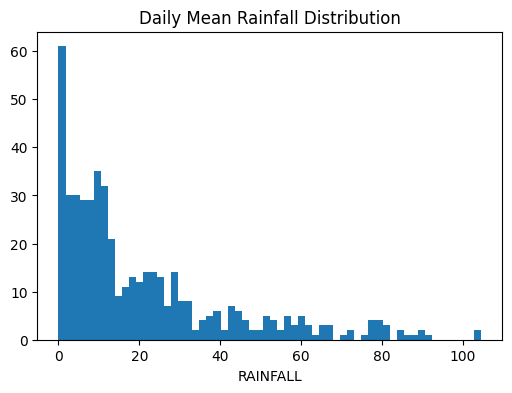

In [116]:
plt.figure(figsize=(6,4))
rain_mean.plot.hist(bins=60)
plt.title("Daily Mean Rainfall Distribution")
plt.show()

In [118]:
#Threshold application
rain_event = (rain_mean >= 12).astype(int)

In [124]:
rain_event.to_series().value_counts(normalize=True)

RAINFALL
0    0.5
1    0.5
Name: proportion, dtype: float64

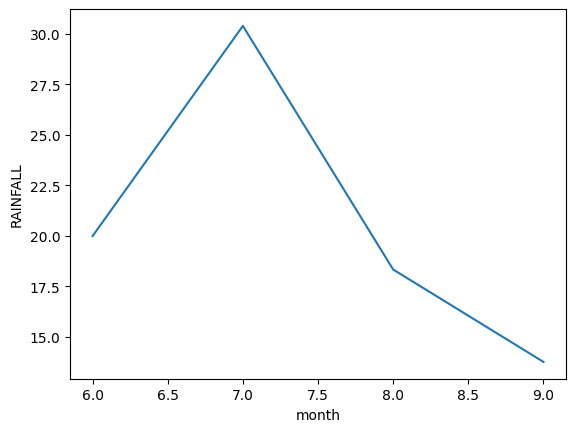

In [130]:
rain_mean.groupby("TIME.month").mean().plot()

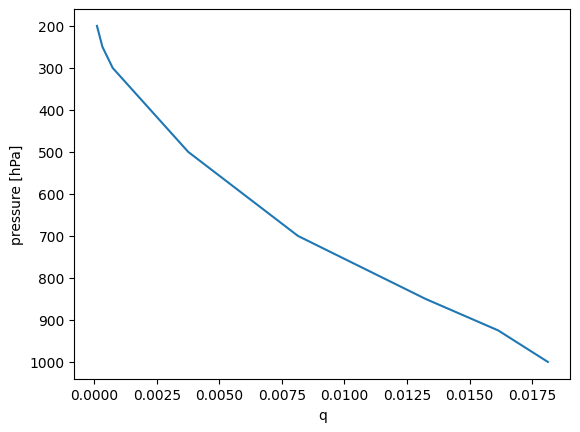

In [132]:
era_konkan["q"].mean(
    dim=["time", "latitude", "longitude"]
).plot(y="pressure_level", yincrease=False)

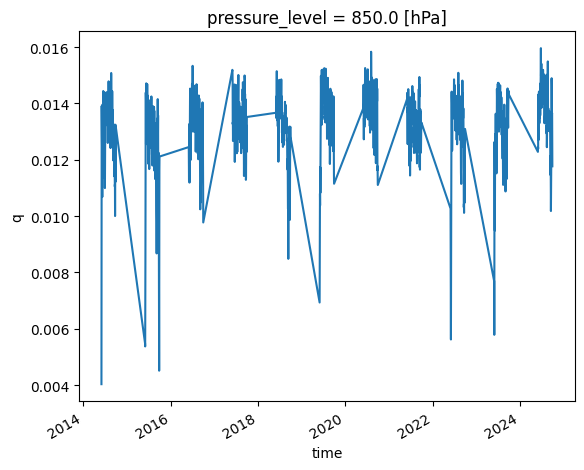

In [134]:
q850 = era_konkan["q"].sel(pressure_level=850).mean(
    dim=["latitude", "longitude"]
)
q850.plot()

In [140]:
len(common_time)

488

In [151]:
rain_common = rain_mean.sel(TIME=common_time)
q850_common = q850.sel(time=common_time)

In [157]:
rain_tomorrow = rain_common.shift(TIME=-1)

X_q850 = q850_common.isel(time=slice(0, -1))
y_rain = rain_tomorrow.isel(TIME=slice(0, -1))

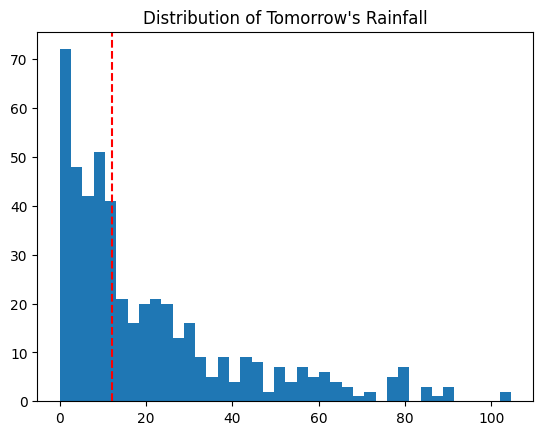

In [159]:
plt.hist(y_rain, bins=40)
plt.axvline(12, color="red", linestyle="--")
plt.title("Distribution of Tomorrow's Rainfall")
plt.show()

In [161]:
rain_event = (y_rain >= 12)
rain_event.to_series().value_counts(normalize=True)

RAINFALL
True     0.501027
False    0.498973
Name: proportion, dtype: float64

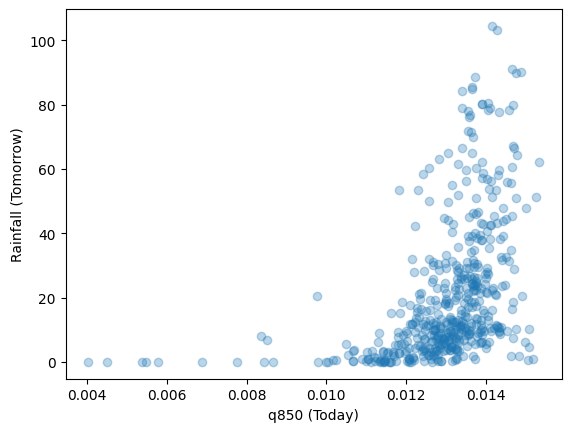

In [163]:
plt.scatter(X_q850.values, y_rain.values, alpha=0.3)
plt.xlabel("q850 (Today)")
plt.ylabel("Rainfall (Tomorrow)")
plt.show()

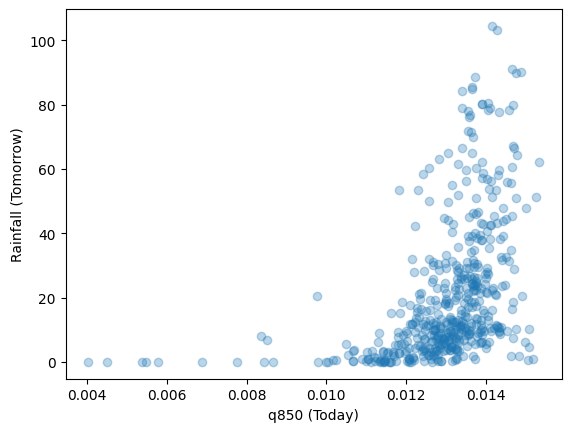

In [165]:
plt.scatter(X_q850.values, y_rain.values, alpha=0.3)
plt.xlabel("q850 (Today)")
plt.ylabel("Rainfall (Tomorrow)")
plt.show()

In [167]:
q_extreme = X_q850.where(y_rain >= 12).mean()
q_normal = X_q850.where(y_rain < 12).mean()

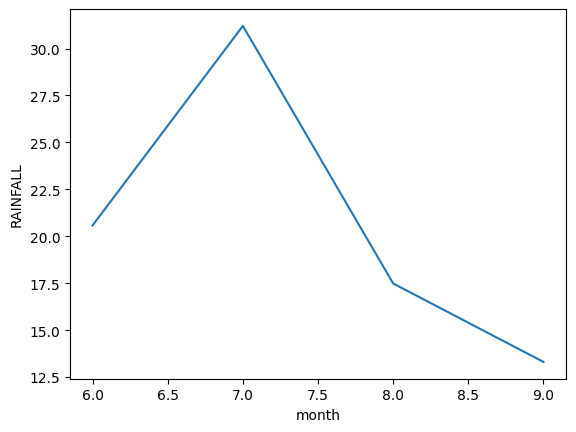

In [171]:
y_rain.groupby("TIME.month").mean().plot()